Importing

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

def read_csv_file(filepath):
    try:
        df = pd.read_csv(filepath, error_bad_lines=False)
    except pd.errors.ParserError as e:
        print(f"Error reading file {filepath}: {e}")
        return None
    return df

def process_directory(root_dir, parent_dirs, lambda_dirs):
    dfs = []
    for parent_dir in parent_dirs:
        for lambda_dir in lambda_dirs:
            for subdir in ['1', '10', '100']:
                for root, dirs, files in os.walk(os.path.join(root_dir, parent_dir, lambda_dir, subdir)):
                    for file in files:
                        if file == 'log.csv':
                            filepath = os.path.join(root, file)
                            print(filepath)
                            df = read_csv_file(filepath)
                            if df is not None:
                                seed = root.split('/')[-3]  # -3 as there's an additional level
                                df['seed'] = seed
                                df['boed_type'] = parent_dir
                                df['num_designs'] = subdir
                                df['lambda_subdir'] = lambda_dir
                                dfs.append(df)
    
    return pd.concat(dfs, ignore_index=True)

root_dir = 'neurips_bmp'
parent_dirs = ['BMP', 'BMP_lf_pce']
lambda_dirs = ['eig_lambda_0-5']
final_df = process_directory(root_dir, parent_dirs, lambda_dirs)


In [9]:
final_df.shape

(6000, 10)

In [10]:
final_df.head()

,STEP,Xi,Loss,EIG,inference_time,simulate_time,seed,boed_type,num_designs,lambda_subdir
0,0,[[45.06356]],18.560911,-8.321772,79.615838,9.622302,1,BMP,1,eig_lambda_0-5
1,1,[[119.476456]],17.053823,-7.476764,17.978917,8.292756,1,BMP,1,eig_lambda_0-5
2,2,[[108.24939]],17.082542,-7.428301,17.941431,8.699596,1,BMP,1,eig_lambda_0-5
3,3,[[73.359344]],17.387360,-7.538582,18.010159,8.833731,1,BMP,1,eig_lambda_0-5
4,4,[[56.204376]],17.207357,-7.404818,18.061980,8.699123,1,BMP,1,eig_lambda_0-5


In [11]:
# Replacing the 'boed_type' values
final_df['boed_type'] = final_df['boed_type'].replace({'BMP': 'NF-PCE', 'BMP_lf_pce': 'LF-PCE'})


In [12]:
final_df.head()

,STEP,Xi,Loss,EIG,inference_time,simulate_time,seed,boed_type,num_designs,lambda_subdir
0,0,[[45.06356]],18.560911,-8.321772,79.615838,9.622302,1,NF-PCE,1,eig_lambda_0-5
1,1,[[119.476456]],17.053823,-7.476764,17.978917,8.292756,1,NF-PCE,1,eig_lambda_0-5
2,2,[[108.24939]],17.082542,-7.428301,17.941431,8.699596,1,NF-PCE,1,eig_lambda_0-5
3,3,[[73.359344]],17.387360,-7.538582,18.010159,8.833731,1,NF-PCE,1,eig_lambda_0-5
4,4,[[56.204376]],17.207357,-7.404818,18.061980,8.699123,1,NF-PCE,1,eig_lambda_0-5


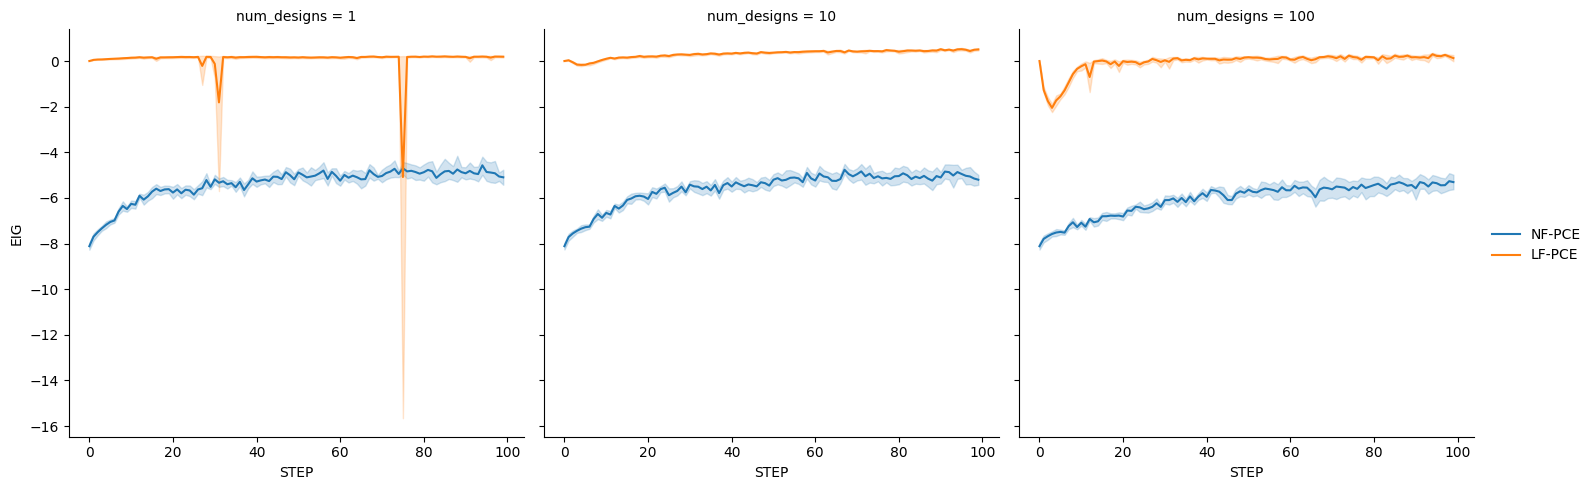

In [13]:
import seaborn as sns

# Convert num_designs to integer
final_df['num_designs'] = final_df['num_designs'].astype(int)

# Create a grid of plots
g = sns.FacetGrid(final_df, col="num_designs", height=5, aspect=1)

# Add the line plots
g = g.map(sns.lineplot, "STEP", "EIG", "boed_type")

# Add a legend
g.add_legend()

plt.show()


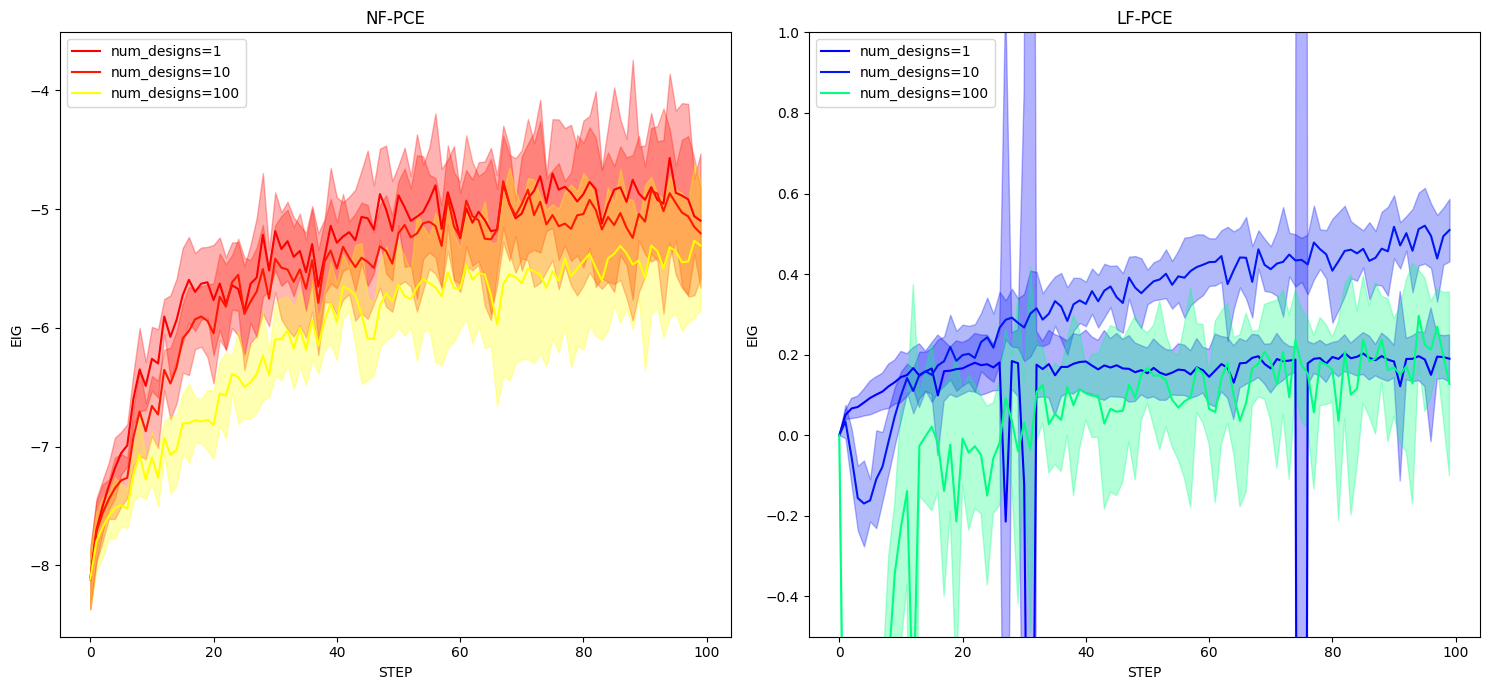

In [21]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Define the color maps
cmaps = {'LF-PCE': cm.winter, 'NF-PCE': cm.autumn}

# Define the unique number of designs
num_designs_unique = final_df['num_designs'].unique()

# Sort the unique designs for proper color mapping
num_designs_unique_sorted = np.sort(num_designs_unique)

# Get the boed_types
boed_types = final_df['boed_type'].unique()

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

for i, boed_type in enumerate(boed_types):
    ax = axs[i]
    
    for num_designs in num_designs_unique_sorted:
        df_designs = final_df[(final_df['boed_type'] == boed_type) & (final_df['num_designs'] == num_designs)]
        
        # Group by STEP and calculate mean and std
        df_grouped = df_designs.groupby('STEP')['EIG'].agg(['mean', 'std']).reset_index()

        # Create color map based on the unique values of num_designs
        color = cmaps[boed_type]((num_designs - num_designs_unique_sorted.min()) / (num_designs_unique_sorted.max() - num_designs_unique_sorted.min()))

        # Plot mean line
        ax.plot(df_grouped['STEP'], df_grouped['mean'], color=color, label=f"num_designs={num_designs}")
        
        # Fill between for standard deviation
        ax.fill_between(df_grouped['STEP'], df_grouped['mean'] - df_grouped['std'], df_grouped['mean'] + df_grouped['std'], color=color, alpha=0.3)

    ax.set_title(boed_type)
    ax.set_xlabel('STEP')
    ax.set_ylabel('EIG')

    # Customize y-axis for LF-PCE
    if boed_type == 'LF-PCE':
        ax.set_ylim([-0.5, 1.])

    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [28]:
# Calculate average inference time and standard deviation for each boed_type and num_designs combination
stats = final_df.groupby(['boed_type', 'num_designs'])['inference_time'].agg(['mean', 'std'])

# Display as a table
print(stats)

                            mean       std
boed_type num_designs                     
LF-PCE    1            16.956060  5.922511
          10           30.638348  6.961934
          100          80.366638  7.024579
NF-PCE    1            18.642567  6.508186
          10           18.030480  6.195232
          100          22.981841  7.148911


## Calculating total time

# MINEBED

In [ ]:
import os
import pandas as pd

def extract_directory_structure(root_dir):
    df = pd.DataFrame(columns=['num_designs', 'seed', 'log_path'])
    
    for num_designs_dir in os.listdir(root_dir):
        num_designs_path = os.path.join(root_dir, num_designs_dir)
        if not os.path.isdir(num_designs_path):
            continue

        for seed_dir in os.listdir(num_designs_path):
            seed_path = os.path.join(num_designs_path, seed_dir)
            if not os.path.isdir(seed_path):
                continue

            for log_dir in os.listdir(seed_path):
                log_path = os.path.join(seed_path, log_dir)
                if not os.path.isdir(log_path):
                    continue

                log_csv = os.path.join(log_path, 'log.csv')
                if not os.path.isfile(log_csv):
                    continue

                df = df.append({'num_designs': num_designs_dir, 'seed': seed_dir, 'log_path': log_csv}, ignore_index=True)
    
    return df

root_directory = 'neurips_BMP_minebed'
directory_df = extract_directory_structure(root_directory)
print(directory_df)


In [32]:
directory_df.head()

,num_designs,seed,log_path
0,1,9,neurips_BMP_minebed/1/9/2023.05.14.11.10/log.csv
1,1,7,neurips_BMP_minebed/1/7/2023.05.14.11.10/log.csv
2,1,6,neurips_BMP_minebed/1/6/2023.05.14.11.05/log.csv
3,1,1,neurips_BMP_minebed/1/1/2023.05.14.11.06/log.csv
4,1,10,neurips_BMP_minebed/1/10/2023.05.14.11.17/log.csv


In [41]:
import os
import pandas as pd

def read_csv_file(filepath):
    try:
        df = pd.read_csv(filepath, error_bad_lines=False)
    except pd.errors.ParserError as e:
        print(f"Error reading file {filepath}: {e}")
        return None
    return df

def process_directory(root_dir):
    dfs = []
    for num_designs_dir in os.listdir(root_dir):
        num_designs_path = os.path.join(root_dir, num_designs_dir)
        if not os.path.isdir(num_designs_path):
            continue

        for seed_dir in os.listdir(num_designs_path):
            seed_path = os.path.join(num_designs_path, seed_dir)
            if not os.path.isdir(seed_path):
                continue

            for log_dir in os.listdir(seed_path):
                log_path = os.path.join(seed_path, log_dir)
                if not os.path.isdir(log_path):
                    continue

                log_csv = os.path.join(log_path, 'log.csv')
                if not os.path.isfile(log_csv):
                    continue

                df = read_csv_file(log_csv)
                if df is not None:
                    df['seed'] = seed_dir
                    df['num_designs'] = num_designs_dir
                    dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

root_directory = 'neurips_BMP_minebed'
directory_df = process_directory(root_directory)
# print(directory_df)


/var/folders/j7/tj9yr2g9655ccsm2fwyzbxv40000gn/T/ipykernel_65120/2081354513.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(filepath, error_bad_lines=False)
/var/folders/j7/tj9yr2g9655ccsm2fwyzbxv40000gn/T/ipykernel_65120/2081354513.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(filepath, error_bad_lines=False)
/var/folders/j7/tj9yr2g9655ccsm2fwyzbxv40000gn/T/ipykernel_65120/2081354513.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(filepath, error_bad_lines=False)
/var/folders/j7/tj9yr2g9655ccsm2fwyzbxv40000gn/T/ipykernel_65120/2081354513.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future ver

In [42]:
directory_df.head()

,seed,EIG,opt_design,inference_time,num_designs
0,9,1.780164,[1000.],-678.121402,1
1,7,1.862346,[1000.],-539.385641,1
2,6,1.807362,[1000.],-694.948462,1
3,1,1.921837,[1000.],-864.619724,1
4,10,1.810307,[1000.],-582.023110,1


In [38]:
directory_df

,seed,EIG,opt_design,inference_time,num_designs
0,9,1.780164,[1000.],-678.121402,1
1,7,1.862346,[1000.],-539.385641,1
2,6,1.807362,[1000.],-694.948462,1
3,1,1.921837,[1000.],-864.619724,1
4,10,1.810307,[1000.],-582.023110,1
5,8,1.841953,[1000.],-594.215035,1
6,4,1.817170,[1000.],-611.257134,1
7,3,1.792693,[1000.],-676.287663,1
8,2,1.823045,[997.77776855],-831.378149,1
9,5,1.805112,[899.34306985],-700.337584,1


In [43]:
def calculate_mean_std(df):
    agg_df = df.groupby('num_designs')['EIG'].agg(['mean', 'std'])
    agg_df.rename(columns={'mean': 'EIG_mean', 'std': 'EIG_std'}, inplace=True)
    return agg_df

# Assuming you have the DataFrame 'directory_df' containing the information from the CSV files
mean_std_df = calculate_mean_std(directory_df)
print(mean_std_df)

             EIG_mean   EIG_std
num_designs                    
1            1.826199  0.040943
10           2.063852  0.064051
100          2.175297  0.109201


In [44]:
import pandas as pd

def calculate_time_mean_std(df):
    df['inference_time'] = -df['inference_time'] / 60.  # Take the negative of 'inference_time' column
    agg_df = df.groupby('num_designs')['inference_time'].agg(['mean', 'std'])
    agg_df.rename(columns={'mean': 'inference_time_mean', 'std': 'inference_time_std'}, inplace=True)
    return agg_df

# Assuming you have the DataFrame 'directory_df' containing the information from the CSV files
mean_std_df = calculate_time_mean_std(directory_df)
print(mean_std_df)


             inference_time_mean  inference_time_std
num_designs                                         
1                      11.287623            1.748328
10                     14.507309            5.545508
100                    24.867998            5.930699
